<a href="https://colab.research.google.com/github/Renan-Domingues/IntroductionToPytorch/blob/main/IntorductionPytorch_06_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training with PyTorch


- We'll get familiar with dataset and dataLoader abstraction
- We'll discuss specific loss functions and when use them
- We'll look at PyTorch Optimizers,  witch adjust model weights based the loss function outcome


### Dataset and DataLoader

The dataset and dataLoader classes encapsulate the processing of pulling our data from the storage and exposing it to the training loop in batches

The Dataset is responsible for accessing and processing single instances of data

The DataLoader pulls instances of data from dataset, collects them in batches, and return them for consumption by your training loop

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))]
)

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data',
                                                 train=True,
                                                 transform=transform,
                                                 download=True)

validation_set = torchvision.datasets.FashionMNIST('./data',
                                                   train=False,
                                                   transform=transform,
                                                   download=True)

# Create data loaders, shuffle for training but not for validation

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print(f'training set has {len(training_set)} instances')
print(f'Validation set has {len(validation_set)} instances')

100%|██████████| 26421880/26421880 [00:01<00:00, 14948184.05it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 266935.66it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5024223.66it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13126004.25it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

training set has 60000 instances
Validation set has 10000 instances


Coat Sandal Coat Sandal


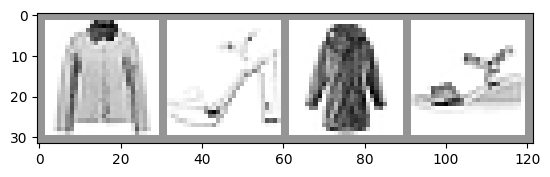

In [ ]:
# Let's visualize

import matplotlib.pyplot as plt
import numpy as np

# helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
  if one_channel:
    img = img.mean(dim=0)
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap="Greys")
  else:
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# create a grid from the images and show them
img_grid = torchvision.utils. make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print(' '.join(classes[labels[j]] for j in range(4)))

### The Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()


### Loss Function

For demonstration purposes, we'll create batches of dummy output and label values, run them through the loss function, and examine the result.

In [ ]:
# We will use the cross-entropy loss

loss_fn = torch.nn.CrossEntropyLoss()

# Loss function expect data in batches, so we're creating batches of 4
dummy_outputs = torch.rand(4, 10)
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print(f'Total loss for this batch {loss.item()}')

tensor([[0.2743, 0.4102, 0.6050, 0.1525, 0.0546, 0.3288, 0.7227, 0.4026, 0.5552,
         0.5784],
        [0.5115, 0.6881, 0.2108, 0.5930, 0.7337, 0.4290, 0.9829, 0.6173, 0.9984,
         0.0166],
        [0.8128, 0.3581, 0.3261, 0.4107, 0.2350, 0.6834, 0.0113, 0.4701, 0.6434,
         0.6005],
        [0.5076, 0.0376, 0.9616, 0.8752, 0.0828, 0.0604, 0.7334, 0.7538, 0.4191,
         0.0747]])
tensor([1, 5, 3, 7])
Total loss for this batch 2.3112785816192627


### Optimizer

We'll  use the stochastic gradient descent woth momentum.

momentum - it push the optimizer in the direction of strongest gradient over multiple steps


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### The Training Loop

what is happening in each pass of the loop:



- Gets a batch of training data from the DataLoader

- Zeros the optimizer's gradients

- Performs an inference - that is, gets predictions from the model for an input batch

- Calculates the loss for that set of predictions vs. the labels on the dataset

- Calculates the backward gradients over the learning weights

- Tells the optimizer to perform one learning step - that is, adjust the model's learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose

- It reports on the loss for every 1000 batches.

- Finally, it reports the average per-batch loss for the last 1000 batches, for comparison with a validation run


In [ ]:
def train_one_epoch(epoch_index, tb_writer):
  running_loss = 0
  last_loss = 0

  for i, data in enumerate(training_loader):
    # Every data instance is an input + label pair
    inputs, labels = data

    #zero the gradients for every batch
    optimizer.zero_grad()

    # Make prediction for this batch
    outputs = model(inputs)

    # compute the loss and its gradients
    loss = loss_fn(outputs, labels)
    loss.backward()

    # adjust the learning weights
    optimizer.step()

    # Gather data and report
    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000 # loss per batch
      print(f' batch: {i + 1} loss: {last_loss}')
      tb_x = epoch_index * len(training_loader) + i + 1
      tb_writer.add_scalar('Loss/train', last_loss, tb_x)
      running_loss = 0.

  return last_loss

### Per-Epoch Activity

Here, we'll do our reporting in TensorBoard. This will require going to the command line to start TensorBoard, and opening it in another browser tab.

In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/fashion_trainer_{timestamp}')
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch  in range(EPOCHS):
  print(f'EPOCH {epoch_number + 1}')

  model.train(True)
  avg_loss = train_one_epoch(epoch_number, writer)

  running_vloss = 0.0

  model.eval()

  with torch.no_grad():
    for i, vdata in  enumerate(validation_loader):
      vinputs, vlabels = vdata
      voutputs = model(vinputs)
      vloss = loss_fn(voutputs, vlabels)
      running_vloss += vloss

  avg_vloss = running_vloss / (i + 1)
  print(f" LOSS train {avg_loss} valid {avg_vloss}")

  writer.add_scalars('training vcs validation loss',
                     {'training': avg_loss, 'Validation': avg_vloss},
                     epoch_number + 1)
  writer.flush()

  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = f'model_{timestamp}_{epoch_number}'
    torch.save(model.state_dict(), model_path)

  epoch_number += 1





EPOCH 1
 batch: 1000 loss: 1.7072935178428887
 batch: 2000 loss: 0.8224790668487549
 batch: 3000 loss: 0.7125203360076994
 batch: 4000 loss: 0.6510529834385961
 batch: 5000 loss: 0.6054272835507291
 batch: 6000 loss: 0.5682494880040176
 batch: 7000 loss: 0.5584115169532597
 batch: 8000 loss: 0.5145772430835059
 batch: 9000 loss: 0.4899272675893735
 batch: 10000 loss: 0.4878806865841616
 batch: 11000 loss: 0.4642151725580916
 batch: 12000 loss: 0.44265515326836613
 batch: 13000 loss: 0.45018164464685834
 batch: 14000 loss: 0.428365321966121
 batch: 15000 loss: 0.40540716868510934
 LOSS train 0.40540716868510934 valid 0.45086997747421265
EPOCH 2
 batch: 1000 loss: 0.3844018662413728
 batch: 2000 loss: 0.3927876336658992
 batch: 3000 loss: 0.41265662166522815
 batch: 4000 loss: 0.3989526324522449
 batch: 5000 loss: 0.3560462340557133
 batch: 6000 loss: 0.382255077167054
 batch: 7000 loss: 0.38062660212029004
 batch: 8000 loss: 0.38010720060544556
 batch: 9000 loss: 0.368526779780339
 batc